In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from geopy.distance import vincenty
%matplotlib inline

In [3]:
train = pd.read_csv('C:\Users\Steven\Documents\Git\personal_projects\NewYorkTaxiTripDuration\\train.csv', parse_dates = True)
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])

In [4]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB


In [6]:
train.describe() #duration is in seconds

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


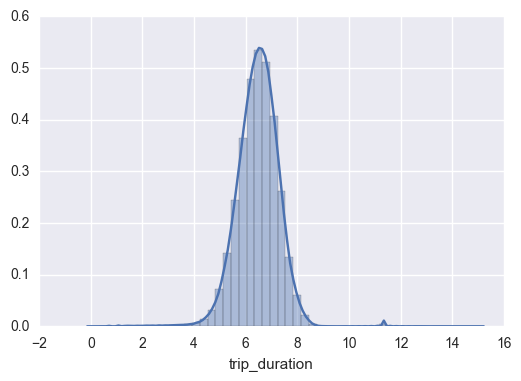

In [7]:
sns.distplot(np.log(train['trip_duration']))

In [8]:
#sns.boxplot(x = "passenger_count", y = "trip_duration", data = train)
#plt.ylim(0, 3000)

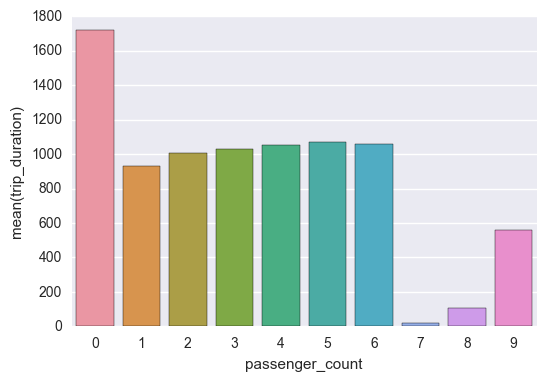

In [9]:
sns.barplot(x = "passenger_count", y = "trip_duration", n_boot = 0, data = train)

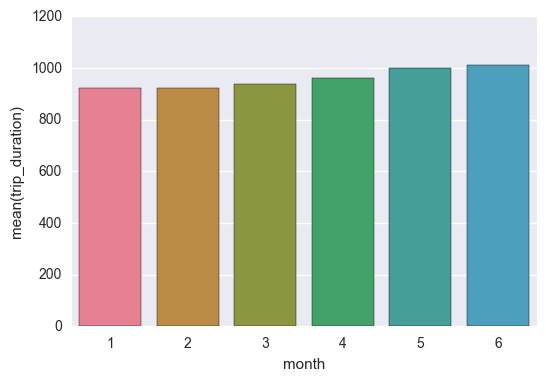

In [16]:
train['month'] = train['pickup_datetime'].apply(lambda x: x.month)

with sns.color_palette("husl", 8):
    sns.barplot(x = "month", y = "trip_duration", n_boot = 0, data = train)

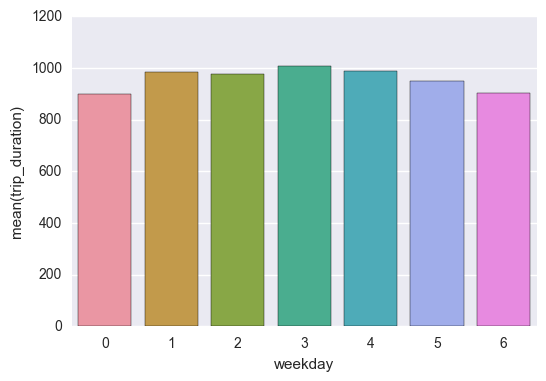

In [17]:
train['weekday'] = train['pickup_datetime'].apply(lambda x: x.weekday())
sns.barplot(x = "weekday", y = "trip_duration", n_boot = 0, data = train)

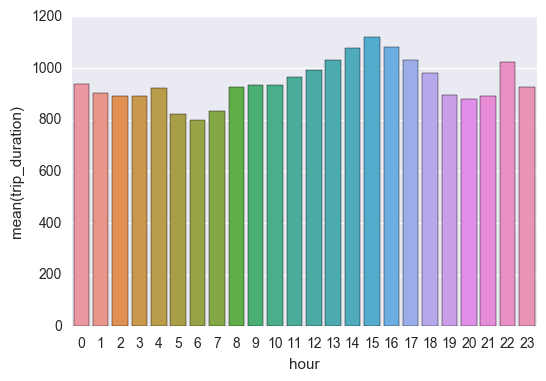

In [18]:
train['hour'] = train['pickup_datetime'].apply(lambda x: x.hour)
sns.barplot(x = "hour", y = "trip_duration", n_boot = 0, data = train)

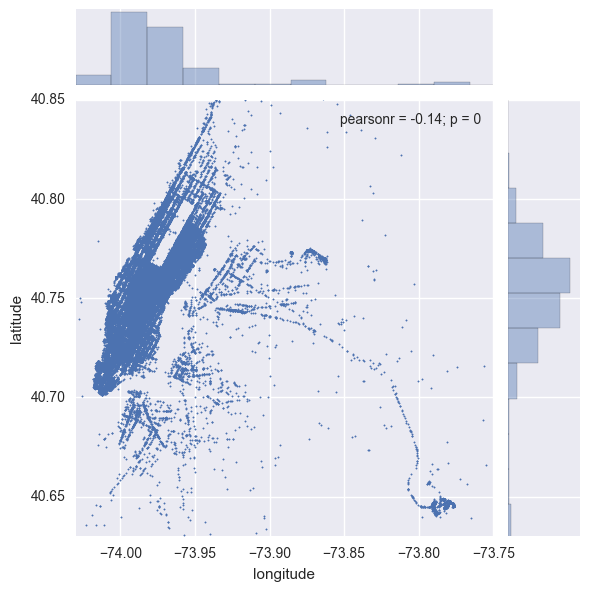

In [19]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

sns.jointplot(x = 'pickup_longitude', y = 'pickup_latitude', data = train.loc[:100000,:], kind = 'scatter', xlim = city_long_border, ylim = city_lat_border, s=1).set_axis_labels('longitude', 'latitude')

In [35]:
train['pickup_coord'] = list(zip(train['pickup_latitude'], train['pickup_longitude']))
train['dropoff_coord'] = list(zip(train['dropoff_latitude'], train['dropoff_longitude']))
train['distance'] = vincenty(train['pickup_coord'], train['dropoff_coord']).miles

TypeError: __new__() takes at most 4 arguments (5 given)